In [1]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
import idx2numpy as idx
%matplotlib inline

In [2]:
train_images = idx.convert_from_file("./data/train-images-ubyte")
train_labels = idx.convert_from_file("./data/train-labels-ubyte")
test_images = idx.convert_from_file("./data/test-images-ubyte")
test_labels = idx.convert_from_file("./data/test-labels-ubyte")
row_size, col_size = 28, 28

In [3]:
num_dev = 10000
perm = torch.randperm(len(train_images))
train_idx = perm[num_dev:]
dev_idx = perm[:num_dev]

In [4]:
def build_xy(image, label):
    return torch.tensor(image).float() / 255.0, torch.tensor(label).long()

def data_nll(X, Y, model):
    with torch.no_grad():
        logits = model(X)
        loss = F.cross_entropy(logits, Y)
        return loss.item()


In [5]:
X, Y = build_xy(train_images, train_labels)
Xtr, Ytr = X[train_idx], Y[train_idx]
Xdev, Ydev = X[dev_idx], Y[dev_idx]
Xte, Yte = build_xy(test_images, test_labels)

In [6]:
n_hidden = 64

model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(row_size * col_size, n_hidden), nn.BatchNorm1d(n_hidden), nn.ReLU6(),
    nn.Linear(n_hidden, n_hidden), nn.BatchNorm1d(n_hidden), nn.ReLU6(),
    nn.Linear(n_hidden, n_hidden), nn.BatchNorm1d(n_hidden), nn.ReLU6(),
    nn.Linear(n_hidden, 10)
)

with torch.no_grad():
    model[-1].weight *= 0.1

print(sum(p.numel() for p in model.parameters()))

for p in model.parameters():
    p.requires_grad = True

59594


In [7]:
lossi = []

In [8]:
steps = 200000
batch_size = 32

for i in range(steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    loss = F.cross_entropy(model(Xb), Yb)

    for p in model.parameters():
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 50000 else 0.01 if i < 100000 else 0.001
    for p in model.parameters():
        p.data -= lr * p.grad

    lossi.append(loss.item())
    if i % 1000 == 0:
        print(i, loss.item())

0 2.299008369445801
1000 0.14938269555568695
2000 0.032520588487386703
3000 0.04561202600598335
4000 0.0941396951675415
5000 0.032796505838632584
6000 0.0055486285127699375
7000 0.08313173800706863
8000 0.025161128491163254
9000 0.3575381934642792
10000 0.015770431607961655
11000 0.0039849854074418545
12000 0.17316071689128876
13000 0.037717923521995544
14000 0.0010344423353672028
15000 0.1056719571352005
16000 0.06443079560995102
17000 0.22206167876720428
18000 0.013545624911785126
19000 0.07084114104509354
20000 0.012266072444617748
21000 0.015771599486470222
22000 0.002399337012320757
23000 0.009706523269414902
24000 0.014644663780927658
25000 0.013927132822573185
26000 0.12388549000024796
27000 0.004117385018616915
28000 0.015960007905960083
29000 0.0457603819668293
30000 0.08221123367547989
31000 0.005099609028548002
32000 0.003175967140123248
33000 0.005608187988400459
34000 0.0010927000548690557
35000 0.002906235633417964
36000 0.007796674966812134
37000 0.015034054405987263
380

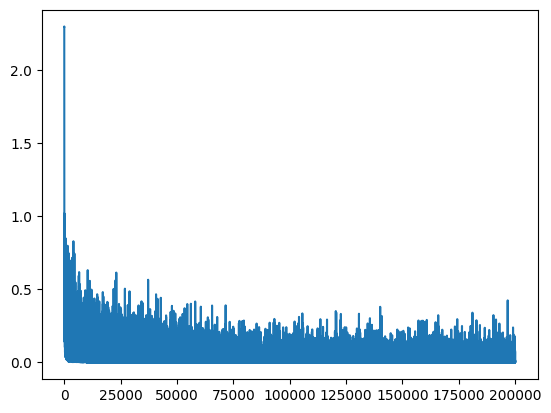

In [9]:
plt.plot(torch.tensor(lossi).view(-1, 1).mean(1))

In [10]:
for layer in model:
    if isinstance(layer, nn.BatchNorm1d):
        layer.training = False

print(data_nll(Xtr, Ytr, model))
print(data_nll(Xdev, Ydev, model))

0.0005637746653519571
0.07446147501468658


In [11]:
def predict(model, X, Y, wrong):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        pred = logits.argmax(dim=1)
        for i in range(X.size(0)):
            if pred[i].item() != Y[i].item():
                wrong.append(i)

In [12]:
wrong = []
predict(model, Xte, Yte, wrong)
print(len(wrong))

183

In [13]:
def predict_wrong(model, X, wrong):
    model.eval()
    with torch.no_grad():
        logits = model(X)
        pred = logits.argmax(dim=1)
        for i in wrong:
            print(f'prediction = {pred[i].item()}')

In [14]:
predict_wrong(model, Xte, wrong)

prediction = 9
prediction = 6
prediction = 7
prediction = 3
prediction = 0
prediction = 0
prediction = 2
prediction = 6
prediction = 1
prediction = 3
prediction = 8
prediction = 9
prediction = 2
prediction = 6
prediction = 5
prediction = 5
prediction = 9
prediction = 5
prediction = 2
prediction = 4
prediction = 6
prediction = 5
prediction = 5
prediction = 2
prediction = 4
prediction = 9
prediction = 3
prediction = 3
prediction = 9
prediction = 3
prediction = 8
prediction = 0
prediction = 9
prediction = 5
prediction = 5
prediction = 6
prediction = 3
prediction = 9
prediction = 3
prediction = 6
prediction = 7
prediction = 6
prediction = 8
prediction = 3
prediction = 3
prediction = 4
prediction = 2
prediction = 2
prediction = 5
prediction = 9
prediction = 3
prediction = 4
prediction = 8
prediction = 9
prediction = 9
prediction = 8
prediction = 0
prediction = 9
prediction = 1
prediction = 3
prediction = 0
prediction = 5
prediction = 0
prediction = 8
prediction = 8
prediction = 1
prediction

In [15]:
print(data_nll(Xte, Yte, model))

0.06949584931135178

In [16]:
percentage_correct = (len(test_labels) - len(wrong)) / len(test_labels) * 100
print(f'{percentage_correct:.2f}%')

98.17%


Final Test Loss: 0.069495

Percentage Correct: 98.17%